In [78]:
#importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


In [50]:
df = pd.read_csv("PreProcessedData.csv")

In [51]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [52]:
df.rename(columns = {'Ground Label': 'label'},inplace=True)

In [53]:
df.head()

,Unnamed: 0,title,text,label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


# 1. Analiza całokształtu zadania - CEL

In [54]:
#Cel: mamy title newsa, text i ground label czyli informacje czy to jest fake czy nie -> 
#musimy stworzyc model klasyfikacji ktory bedzie to stwierdzac

In [100]:
# TODO => TRZEBA ZROBIC PIPELINE!

# 2. Wizualizacja danych

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69045 entries, 0 to 69044
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  69045 non-null  int64 
 1   title       68365 non-null  object
 2   text        68978 non-null  object
 3   label       69045 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


In [56]:
df.shape

(69045, 4)

In [57]:
df['label'].value_counts()

fake    42159
true    26886
Name: label, dtype: int64

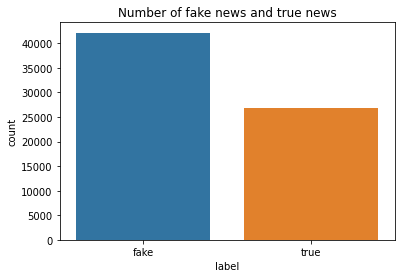

In [58]:
sns.countplot(df['label'])
plt.title('Number of fake news and true news')
plt.show()

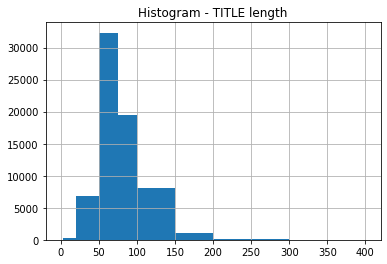

In [59]:
df['title'].str.len().hist(bins=[0,3,20,50,75,100,150,200,300,400])
plt.title('Histogram - TITLE length')
plt.show()

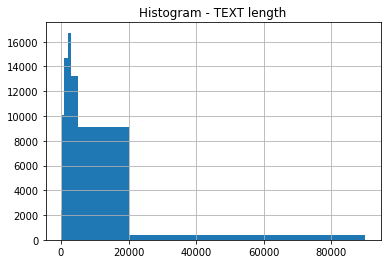

In [60]:
df['text'].str.len().hist(bins=[0,50,200,300,1000,2000,3000,5000,20000,90000])
plt.title('Histogram - TEXT length')
plt.show()

In [61]:
df.isna().sum() #te co nie maja tekstu - usunmy najlepiej, a tytulu doklejmy do textu

Unnamed: 0      0
title         680
text           67
label           0
dtype: int64

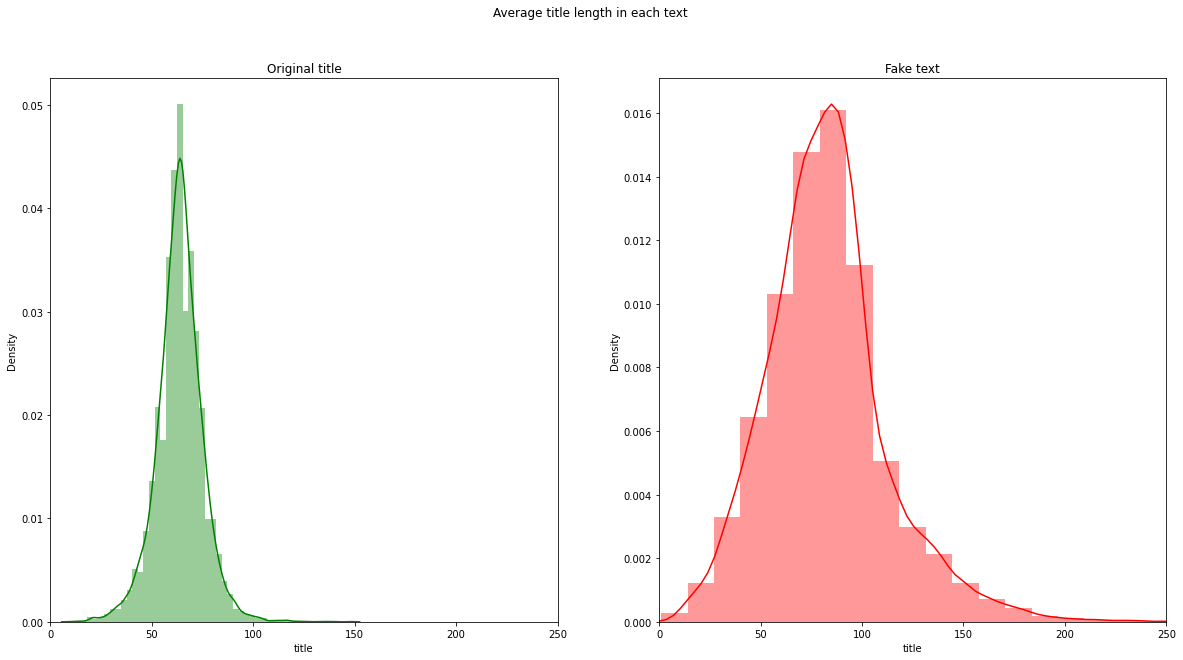

In [62]:
#average title length in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

len_word_true=df[df['label']=='true']['title'].str.len()
sns.distplot(len_word_true.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_xlim([0,250])
ax1.set_title('Original title')

len_word_false=df[df['label']=='fake']['title'].str.len()
sns.distplot(len_word_false.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_xlim([0,250])
ax2.set_title('Fake text')

fig.suptitle('Average title length in each text')

plt.show()

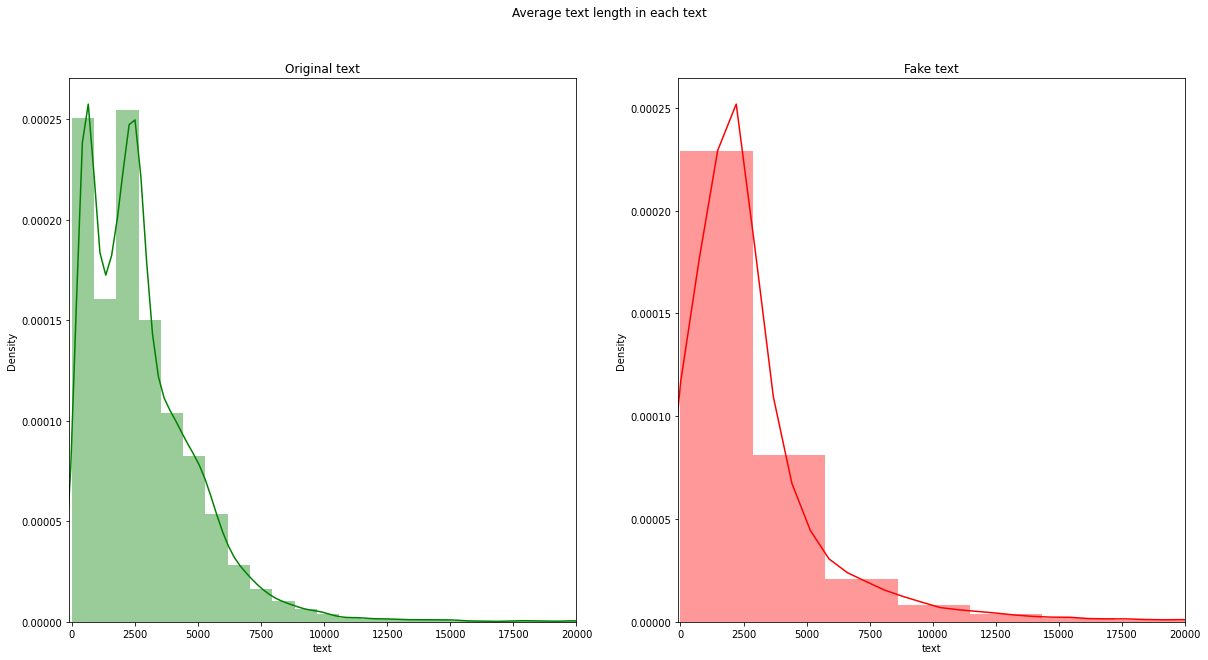

In [63]:
#average word length in each text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
len_word_true=df[df['label']=='true']['text'].str.len()
sns.distplot(len_word_true.map(lambda x: np.mean(x)),ax=ax1,color='green')
ax1.set_title('Original text')
ax1.set_xlim([-100,20000])

len_word_false=df[df['label']=='fake']['text'].str.len()
sns.distplot(len_word_false.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake text')

fig.suptitle('Average text length in each text')
ax2.set_xlim([-100,20000])
plt.show()

In [64]:
df.loc[df['text'].isna()]

,Unnamed: 0,title,text,label
461,461,Il saoule tout le monde avec son analyse polit...,NaN,fake
722,722,La Corée du Nord annonce avoir envoyé un missi...,NaN,fake
739,739,"10/3 Happenings: HBD Cap, Johnny, Dog, Tomato,...",NaN,fake
1889,1889,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,fake
2098,2098,Live Soirée présidentielle US 2016 >> Le Gorafi,NaN,fake
...,...,...,...,...
65006,65006,Nous avons comparé les programmes d’Alain Jupp...,NaN,fake
68020,68020,Ravens @ Raiders - Thursday,NaN,fake
68252,68252,Ne supportant plus l’ambiance de la campagne é...,NaN,fake
68363,68363,Donald Trump s’excuse pour toutes les minorité...,NaN,fake


In [65]:
df.loc[df['title'].isna()]

,Unnamed: 0,title,text,label
170,170,NaN,These SCUMBAGS want to try and CLAIM the e-mai...,fake
271,271,NaN,"No, you'll be a dog licking of the vomit of yo...",fake
414,414,NaN,Many of us do not share Donald Trump's past va...,fake
433,433,NaN,WAS DEFINITELY PAID TO CAUSE PANIC & CONFUSION...,fake
440,440,NaN,Although I may differ greatly with Trey Gowdy'...,fake
...,...,...,...,...
68703,68703,NaN,"So ,you have Rothschild banksters and British ...",fake
68889,68889,NaN,They're going after Arpaio because he was one ...,fake
68890,68890,NaN,I say send him and Hillary to Bengazi and let ...,fake
68902,68902,NaN,Consolidate all the muslim countries into one ...,fake


# 3. Preprocessing

In [66]:
df.head()

,Unnamed: 0,title,text,label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [67]:
#usunm ta jedna kolumne bo jest useless
df.drop(df.columns[0], inplace=True, axis=1)

In [68]:
#Merging title and text into one column
df['text'] = df['title'] + ' ' + df['text']

In [69]:
df.head()

,title,text,label
0,Ann Coulter Make Believes She Has ‘Gay Friend...,Ann Coulter Make Believes She Has ‘Gay Friend...,fake
1,Rating: Moody‘s verbessert Ausblick für Russla...,Rating: Moody‘s verbessert Ausblick für Russla...,fake
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,fake
3,Republicans on Obamacare repeal: 'We're going ...,Republicans on Obamacare repeal: 'We're going ...,true
4,"Trump, on possible DACA deal, says border wall...","Trump, on possible DACA deal, says border wall...",true


In [70]:
df.drop(df.columns[0], inplace=True, axis=1)

In [71]:
df.head()

,text,label
0,Ann Coulter Make Believes She Has ‘Gay Friend...,fake
1,Rating: Moody‘s verbessert Ausblick für Russla...,fake
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,fake
3,Republicans on Obamacare repeal: 'We're going ...,true
4,"Trump, on possible DACA deal, says border wall...",true


In [72]:
label_encoder = preprocessing.LabelEncoder()
df['label']= label_encoder.fit_transform(df['label'])

In [73]:
df.head()

,text,label
0,Ann Coulter Make Believes She Has ‘Gay Friend...,0
1,Rating: Moody‘s verbessert Ausblick für Russla...,0
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,0
3,Republicans on Obamacare repeal: 'We're going ...,1
4,"Trump, on possible DACA deal, says border wall...",1


In [74]:
df.label.value_counts()

0    42159
1    26886
Name: label, dtype: int64

In [75]:
df.shape

(69045, 2)

# 3.1 Text Mining

In [79]:
stopwords = stopwords.words('english')

In [80]:
# STEMMING - Sprawia ze slowa sa w bazowej formie -> dlugo trwa

#SnowballStemmer(language='english')
#stemmer = PorterStemmer()
#Stem words
#words = text.split()
#stemmed_words = [stemmer.stem(word) for word in words]
#text = ' '.join(stemmed_words)

In [81]:
def preprocess_text(text):
    
    #lowercase text
    text = str(text) 
    text = text.lower()
    
    #Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Remove stop words - English
    text = ' '.join(word for word in text.split() if word not in stopwords)
    
    #Get rid of url
    text = re.sub(r'https?://\S+', '', text)
    
    return text

In [82]:
df.iloc[0,0][:300]

' Ann Coulter Make Believes She Has ‘Gay Friends’ To Make A Racist Point (TWEET) It s hard to believe, but Donald Trump does have a sizable amount of supporters who agree with his ideas on immigration and guns. Unsurprisingly, one of those people is Ann Coulter. A racist in her own regard, she falls '

In [83]:
preprocess_text(df.iloc[0,0])[:300]

'ann coulter make believ ‘gay friends’ make racist point tweet hard believ donald trump sizabl amount support agre idea immigr gun unsurprisingli one peopl ann coulter racist regard fall perfectli trump fan baseaft shoot massacr gay nightclub orlando florida coulter tweet gay friend pleas consid poss'

In [84]:
df["text"] = df["text"].apply(preprocess_text)

In [87]:
df.head()

,text,label
0,ann coulter make believ ‘gay friends’ make rac...,0
1,rate moody‘ verbessert ausblick für russland b...,0
2,add dirti money ‘laundering’ obama 17 billion ...,0
3,republican obamacar repeal go get done washing...,1
4,trump possibl daca deal say border wall would ...,1


In [88]:
df.head()

,text,label
0,ann coulter make believ ‘gay friends’ make rac...,0
1,rate moody‘ verbessert ausblick für russland b...,0
2,add dirti money ‘laundering’ obama 17 billion ...,0
3,republican obamacar repeal go get done washing...,1
4,trump possibl daca deal say border wall would ...,1


In [89]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.25) 
# a co zeby zrobic warstwowe probkowanie i zachowac stosunek?

In [90]:
x_train.shape

(51783,)

In [91]:
x_test.shape

(17262,)

In [92]:
tfv = TfidfVectorizer()

In [93]:
tfv.fit(x_train)

TfidfVectorizer()

In [94]:
xtrain_tfv =  tfv.transform(x_train) 
xtest_tfv = tfv.transform(x_test)

# 3.2 PCA - Redukcja wymiarów

# 4. Uczenie modelu

# 4.1 DecisionTree

In [95]:
DT = DecisionTreeClassifier()
DT.fit(xtrain_tfv, y_train)

DecisionTreeClassifier()

In [96]:
DT.score(xtest_tfv, y_test)

0.9450237515930947

In [97]:
DT.score(xtrain_tfv, y_train)

0.9997875750729004

In [98]:
#XD
y_pred = DT.predict(xtest_tfv)
confusion_mat = confusion_matrix(y_test, y_pred)

In [99]:
print(confusion_mat)

[[10115   406]
 [  543  6198]]
